<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/NIFTY_ARIMA_and_GARCH_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install.packages(c("forecast", "rugarch", "quantmod", "tseries"))

# Load required packages

In [2]:
library(quantmod)    # For downloading stock data
library(forecast)    # For ARIMA modeling and forecasting
library(rugarch)     # For GARCH modeling
library(tseries)     # For stationarity test

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [3]:
end_date <- Sys.Date()
start_date <- end_date - 365 * 5

In [4]:
# 1. Download Stock Data
# Download Apple Inc. (AAPL) stock data from Yahoo Finance.
# You can change the ticker symbol and date range as needed
symbol <- getSymbols("^NSEI", from = start_date, to = end_date, src = "yahoo")

Warning message:
“^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


In [5]:
# Extract the Close price (or use Adjusted prices with Ad(AAPL))
close <- Ad(NSEI)

In [6]:
# 2. Compute the Logarithm of the Close Price
log_close <- log(close)

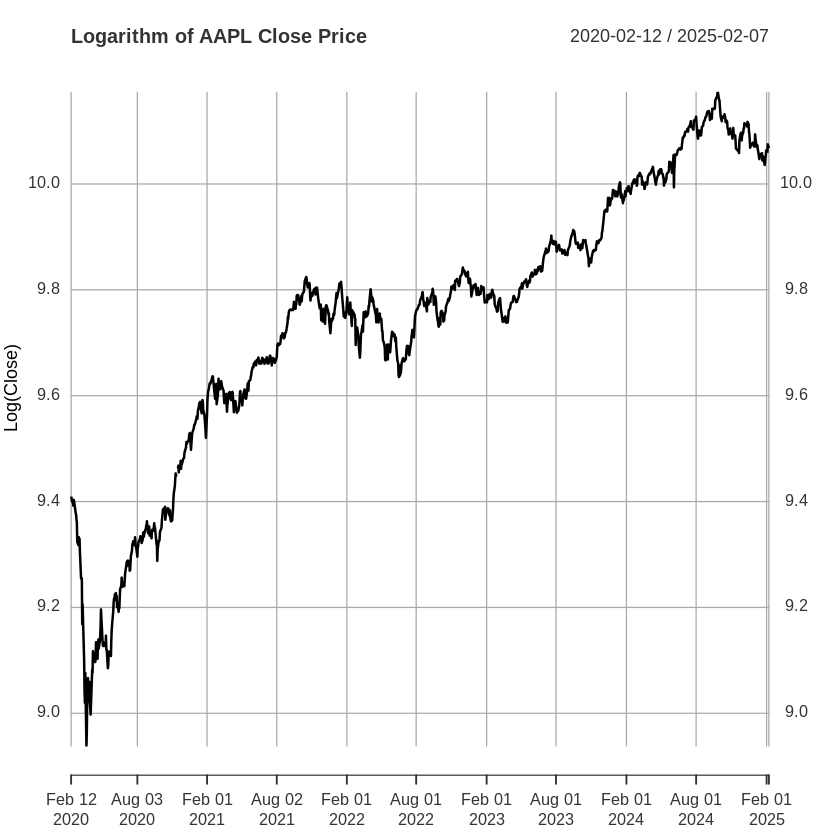

In [7]:
# Plot the log close prices
plot(log_close, main = "Logarithm of AAPL Close Price", ylab = "Log(Close)", xlab = "Date")

In [8]:
# Stock prices are typically non-stationary, so we use log returns
log_returns <- diff(log_close)
log_returns <- na.omit(log_returns)  # Remove the initial N

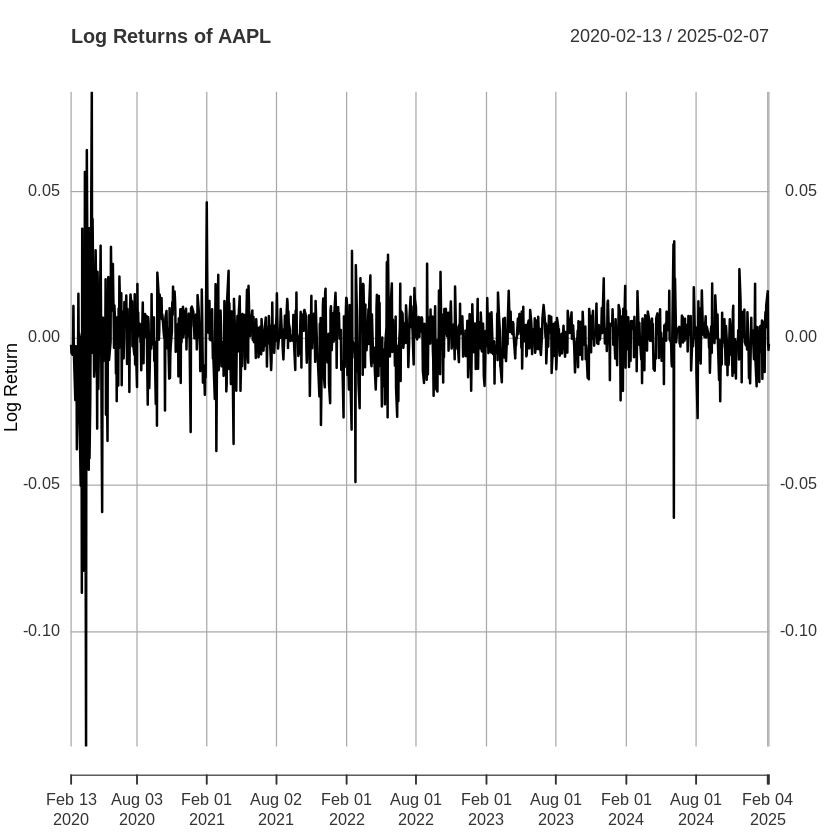

In [9]:
# Plot the log returns
plot(log_returns, main = "Log Returns of AAPL", ylab = "Log Return", xlab = "Date")

In [10]:
# 4. Check Stationarity (Augmented Dickey-Fuller Test)
adf_result <- adf.test(log_returns)
print(adf_result)
# A p-value < 0.05 indicates that the series is stationary

Warning message in adf.test(log_returns):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_returns
Dickey-Fuller = -10.576, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



In [11]:
# 5. Fit an ARIMA Model on Log Returns
# auto.arima() will automatically choose the best ARIMA model for the data.
arima_model <- arima(log_returns, order = c(10, 0, 10))
print(summary(arima_model))

Warning message in arima(log_returns, order = c(10, 0, 10)):
“possible convergence problem: optim gave code = 1”



Call:
arima(x = log_returns, order = c(10, 0, 10))

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


         ar1     ar2      ar3      ar4     ar5      ar6     ar7     ar8     ar9
      0.0193  0.2503  -0.4034  -0.0125  0.1952  -0.5292  -0.448  0.4435  0.0312
s.e.     NaN     NaN      NaN   0.0995  0.1117   0.0786     NaN  0.1895     NaN
        ar10     ma1      ma2     ma3     ma4      ma5     ma6     ma7      ma8
      0.1452  -0.056  -0.2225  0.4338  0.0421  -0.1166  0.4456  0.5554  -0.4306
s.e.  0.1550     NaN      NaN  0.0941  0.1005   0.1180  0.0844     NaN   0.1923
          ma9     ma10  intercept
      -0.0856  -0.0502      6e-04
s.e.      NaN   0.1851      4e-04

sigma^2 estimated as 0.0001359:  log likelihood = 3735.45,  aic = -7426.9

Training set error measures:
                        ME       RMSE         MAE MPE MAPE      MASE
Training set -3.519273e-05 0.01165683 0.007838332 Inf  Inf 0.7260431
                      ACF1
Training set -0.0007785232



	Ljung-Box test

data:  Residuals from ARIMA(10,0,10) with non-zero mean
Q* = 9.5598, df = 3, p-value = 0.0227

Model df: 20.   Total lags used: 23



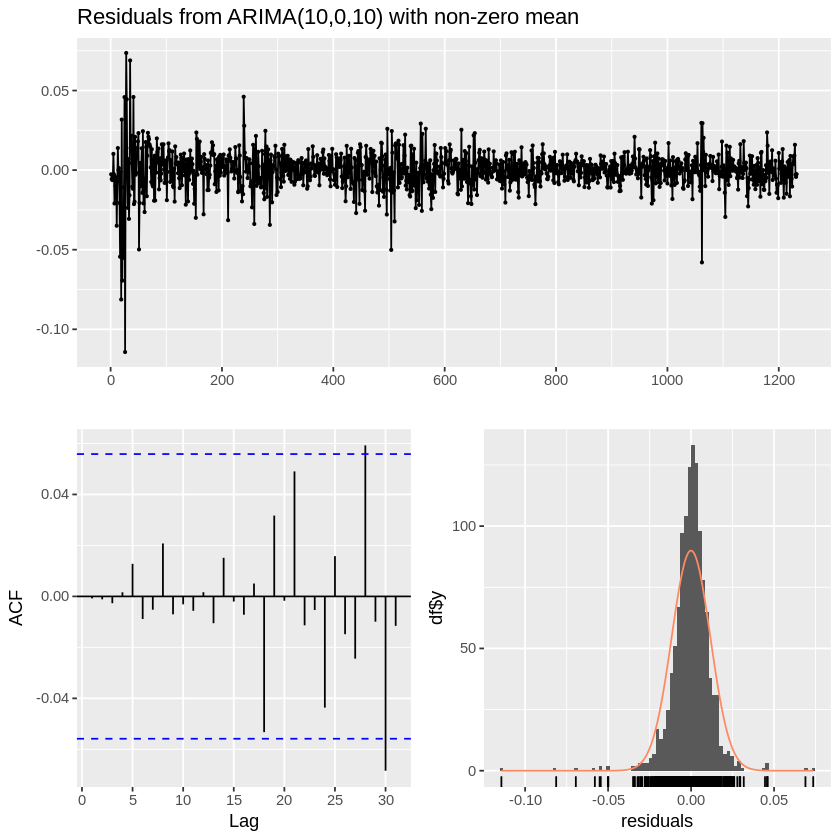

In [12]:
# Check the residuals of the ARIMA model
checkresiduals(arima_model)

In [13]:
# 6. Fit a GARCH Model on the ARIMA Residuals
# Volatility clustering in returns can be modeled with GARCH.
# We first extract the residuals from the ARIMA model.
arima_resid <- residuals(arima_model)

In [14]:
# Specify a standard GARCH(1,1) model.
# Here, we model only the variance with GARCH; the mean model is assumed to be zero.
garch_spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(10, 10)),
  mean.model = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = "std"  # Student's t-distribution to account for fat tails
)

In [15]:
# Fit the GARCH model to the ARIMA residuals
garch_fit <- ugarchfit(spec = garch_spec, data = arima_resid)
print(garch_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(10,10)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
         Estimate  Std. Error   t value Pr(>|t|)
mu       0.000328    0.000236  1.384967 0.166063
omega    0.000017    0.000010  1.649745 0.098995
alpha1   0.120565    0.042661  2.826145 0.004711
alpha2   0.147011    0.011668 12.599743 0.000000
alpha3   0.029397    0.042993  0.683772 0.494119
alpha4   0.000001    0.064003  0.000016 0.999988
alpha5   0.000001    0.038835  0.000013 0.999989
alpha6   0.103618    0.049569  2.090383 0.036583
alpha7   0.000001    0.039135  0.000023 0.999982
alpha8   0.000001    0.029589  0.000035 0.999972
alpha9   0.085967    0.023224  3.701647 0.000214
alpha10  0.007482    0.041436  0.180575 0.856702
beta1    0.000006    0.350570  0.000016 0.999987
beta

In [16]:
# Number of simulation periods (forecast horizon)
n_sim <- 200

In [17]:
# Number of simulated paths
n_paths <- 1000

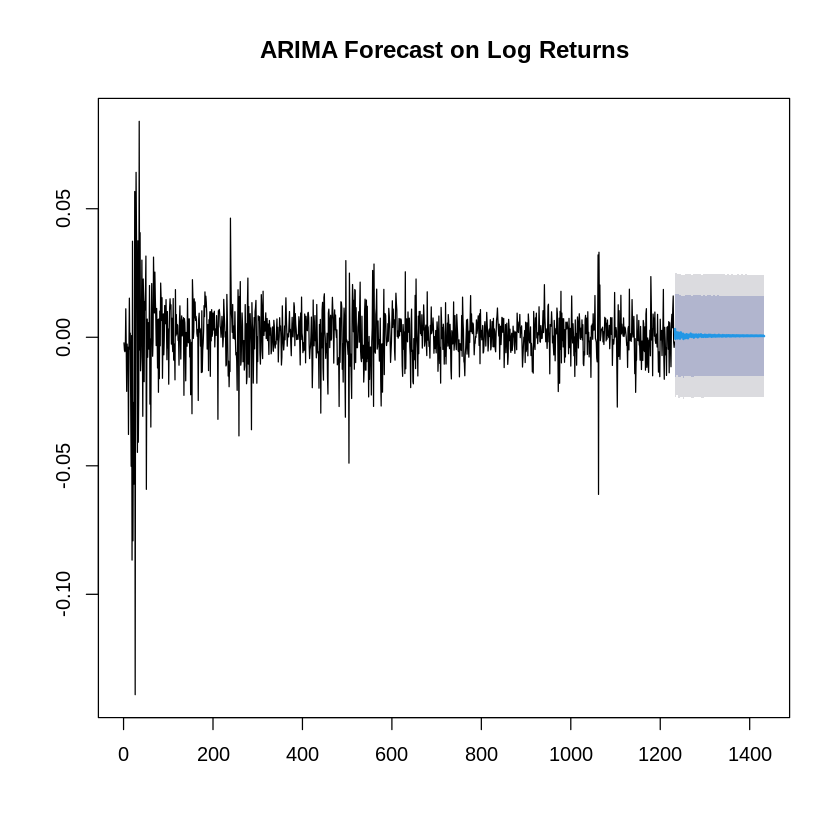

In [18]:
# 7. Forecasting
# Forecast 20 periods ahead using the ARIMA model.
arima_forecast <- forecast(arima_model, h = n_sim)
plot(arima_forecast, main = "ARIMA Forecast on Log Returns")

In [19]:
# Forecast the conditional volatility using the fitted GARCH model.
garch_forecast <- ugarchforecast(garch_fit, n.ahead = n_sim)

# Use sigma() to extract the forecasted volatility (conditional standard deviation)
garch_vol_forecast <- sigma(garch_forecast)

In [20]:
S0 <- as.numeric(last(close))

In [21]:
# Extract the forecasted log return (drift) from the ARIMA model
# (Convert from time-series object to numeric vector)
arima_return_forecast <- as.numeric(arima_forecast$mean)

In [22]:
# Initialize a matrix to store simulated prices for each path.
# Rows: simulation steps (n_sim + 1 including starting price)
# Columns: simulation paths
sim_prices_matrix <- matrix(NA, nrow = n_sim + 1, ncol = n_paths)
sim_prices_matrix[1, ] <- S0  # Set the starting price for all paths

In [23]:
# Set seed for reproducibility
set.seed(123)

In [24]:
for (j in 1:n_paths) {
  for (i in 1:n_sim) {
    # Compute the simulated log return for the period:
    # forecasted drift - 0.5*(volatility^2) + (volatility * random shock)
    simulated_log_return <- arima_return_forecast[i] +
                              garch_vol_forecast[i] * rnorm(1)

    # Update the price using the GBM formula:
    # S_{t+1} = S_t * exp(simulated_log_return)
    sim_prices_matrix[i + 1, j] <- sim_prices_matrix[i, j] * exp(simulated_log_return)
  }
}

In [25]:
# Create a time index for simulation output.
# Starting at the last available date from the observed data.
last_date <- index(close)[length(close)]
sim_dates <- seq.Date(from = last_date, by = "days", length.out = n_sim + 1)

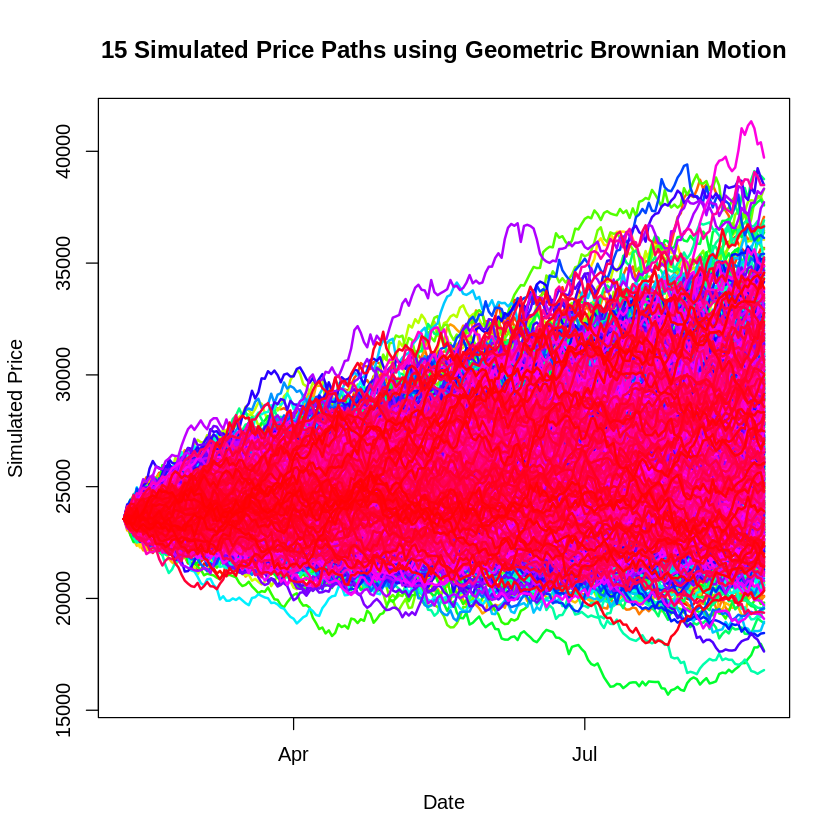

In [26]:
# Plot the simulated paths using different colors for each path.
matplot(sim_dates, sim_prices_matrix, type = "l", lty = 1, lwd = 2,
        col = rainbow(n_paths), xlab = "Date", ylab = "Simulated Price",
        main = "15 Simulated Price Paths using Geometric Brownian Motion")

In [27]:
# Define the confidence level for VaR
high_confidence_level <- 0.975
third_quartile_level <- 0.75
median_level <- 0.5
first_quartile_level <- 0.25
low_confidence_level <- 0.025

# For VaR, we examine the distribution of terminal (final) simulated prices.
final_prices <- sim_prices_matrix[n_sim + 1, ]

In [28]:
return_percent = 100 * (final_prices - S0) / S0

In [29]:
low_ci <- quantile(final_prices, probs = low_confidence_level)
first_quartile <- quantile(final_prices, probs = first_quartile_level)
median <- quantile(final_prices, probs = median_level)
third_quartile <- quantile(final_prices, probs = third_quartile_level)
high_ci <- quantile(final_prices, probs = high_confidence_level)

cat("lower confidence value", low_ci, "\n")
cat("first quartile value", first_quartile, "\n")
cat("median value", median, "\n")
cat("third quartile value", third_quartile, "\n")
cat("higher confidence value", high_ci, "\n")

lower confidence value 20463.79 
first quartile value 24182.11 
median value 26570.56 
third quartile value 29415.68 
higher confidence value 35143.83 


In [30]:
low_ci <- quantile(return_percent, probs = low_confidence_level)
first_quartile <- quantile(return_percent, probs = first_quartile_level)
median <- quantile(return_percent, probs = median_level)
third_quartile <- quantile(return_percent, probs = third_quartile_level)
high_ci <- quantile(return_percent, probs = high_confidence_level)

cat("lower confidence value", low_ci, "\n")
cat("first quartile value", first_quartile, "\n")
cat("median value", median, "\n")
cat("third quartile value", third_quartile, "\n")
cat("higher confidence value", high_ci, "\n")

lower confidence value -13.14162 
first quartile value 2.640758 
median value 12.77853 
third quartile value 24.8546 
higher confidence value 49.16768 


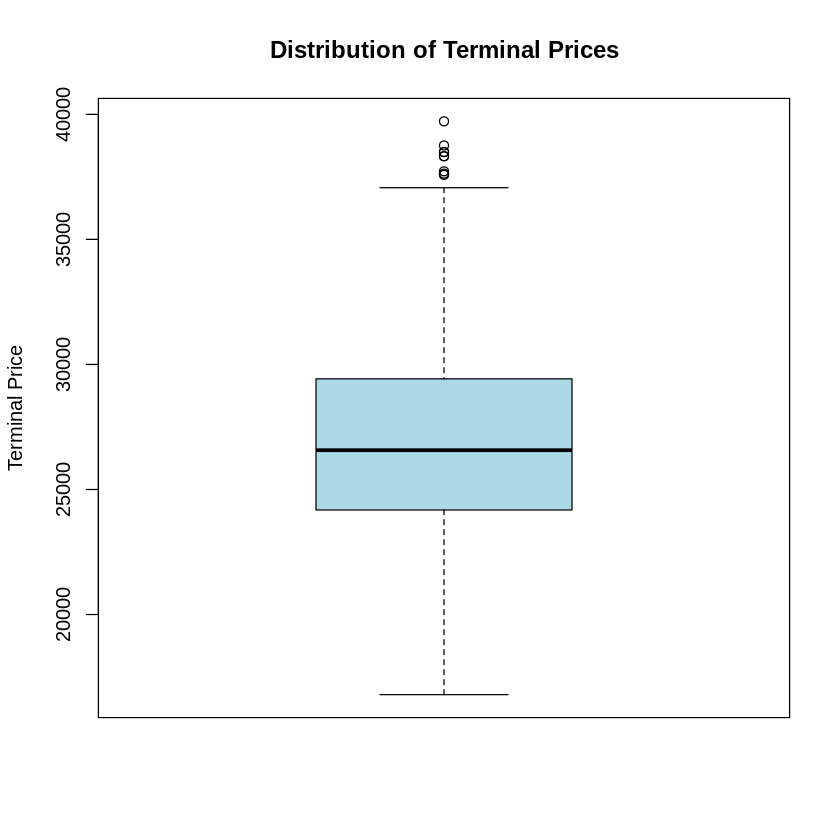

In [31]:
boxplot(final_prices,
        main = "Distribution of Terminal Prices",
        ylab = "Terminal Price",
        col = "lightblue")

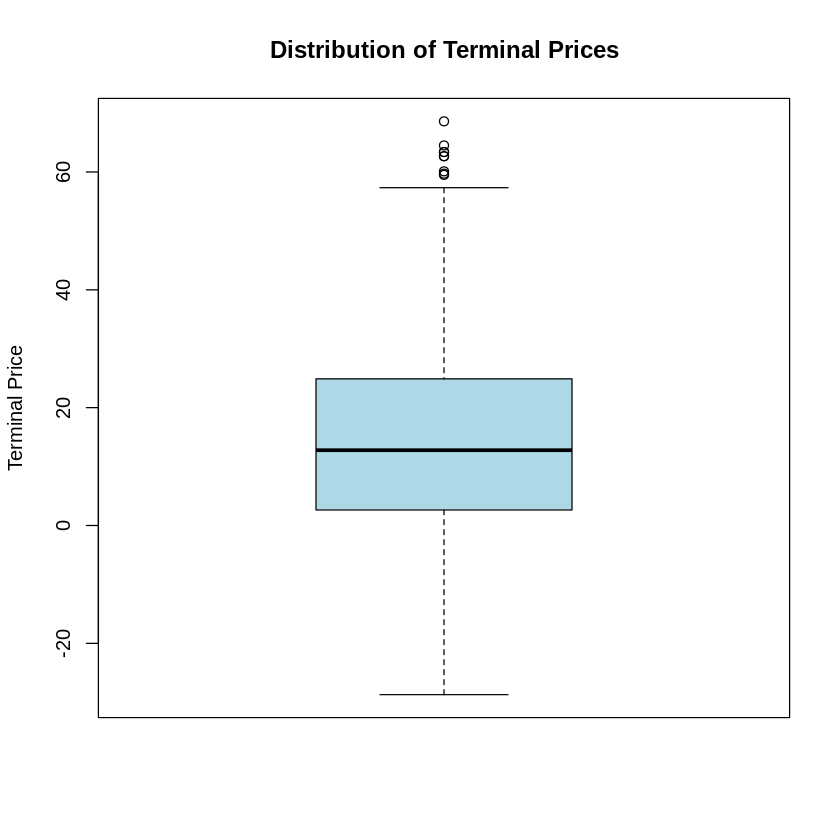

In [32]:
boxplot(return_percent,
        main = "Distribution of Terminal Prices",
        ylab = "Terminal Price",
        col = "lightblue")